# Day 08. Exercise 03
# Overfitting

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load

## 1. Preprocessing

1. Read the file `dayofweek.csv` to a dataframe.
2. Using `train_test_split` with parameters `test_size=0.2`, `random_state=21` get `X_train`, `y_train`, `X_test`, `y_test`.
3. Using, for example, `value_counts()` to check if the distribution of classes is similar in train and test.
4. Use the additional parameter `stratify=` and check the distribution again, now it should be more or less similar in both datasets.

1. Считайте файл `dayofweek.csv` в dataframe.
2. Используя `train_test_split` с параметрами `test_size=0.2`, `random_state=21`, получите `X_train`, `y_train`, `X_test`, `y_test`.
3. Используя, например, `value_counts()`, проверьте, похоже ли распределение классов в train и test.
4. Используйте дополнительный параметр `stratify=` и проверьте распределение еще раз, теперь оно должно быть более или менее похожим в обоих наборах данных.

In [2]:
df = pd.read_csv('../data/dayofweek.csv')
X = df.drop('dayofweek', axis=1)
y = df['dayofweek']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21
)

In [4]:
# Check class distribution
print("Without stratification:")
print("Train distribution:\n", y_train.value_counts(normalize=True))
print("Test distribution:\n", y_test.value_counts(normalize=True))

Without stratification:
Train distribution:
 dayofweek
3    0.232196
6    0.212908
1    0.164688
5    0.160237
2    0.092730
0    0.077893
4    0.059347
Name: proportion, dtype: float64
Test distribution:
 dayofweek
3    0.245562
6    0.204142
5    0.162722
1    0.153846
0    0.091716
4    0.071006
2    0.071006
Name: proportion, dtype: float64


In [5]:
# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21, stratify=y
)

In [6]:
# Check stratified distribution
print("\nWith stratification:")
print("Train distribution:\n", y_train.value_counts(normalize=True))
print("Test distribution:\n", y_test.value_counts(normalize=True))


With stratification:
Train distribution:
 dayofweek
3    0.234421
6    0.211424
1    0.162463
5    0.160979
2    0.088279
0    0.080861
4    0.061573
Name: proportion, dtype: float64
Test distribution:
 dayofweek
3    0.236686
6    0.210059
1    0.162722
5    0.159763
2    0.088757
0    0.079882
4    0.062130
Name: proportion, dtype: float64


## 2. Baseline models

1. Train exactly the same baseline models from the previous exercise and calculate the accuracies using the test dataset with stratification.
2. Did all the models show the similar values of the metric? Which one has the largest difference comparing the current exercise and the previous? Put the answer to the markdown cell in the end of the section.

1. Обучите точно такие же базовые модели из предыдущего упражнения и рассчитайте точность, используя тестовый набор данных со стратификацией.
2. Все ли модели показали схожие значения метрики? Какая из них имеет наибольшую разницу при сравнении текущего упражнения и предыдущего? Поместите ответ в ячейку разметки в конце раздела.

### a. Logreg

In [7]:
models = {
    'Logistic Regression': LogisticRegression(random_state=21, fit_intercept=False, max_iter=1000)
}

previous_accuracies = {
    'Logistic Regression': 0.6406
}

### b. SVM

In [8]:
models = {
    'SVM': SVC(kernel='linear', random_state=21)
}

previous_accuracies = {
    'SVM': 0.7028
}

### c. Decision tree

In [9]:
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=4, random_state=21)
}

previous_accuracies = {
    'Decision Tree': 0.5516
}

### d. Random forest

In [10]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21)
}

previous_accuracies = {
    'Random Forest': 0.9994
}

In [11]:
test_accuracies = {}
largest_diff = 0
largest_diff_model = ''

for name, model in models.items():
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    test_accuracies[name] = acc
    
    diff = previous_accuracies[name] - acc
    if diff > largest_diff:
        largest_diff = diff
        largest_diff_model = name
        
    print(f"{name} Test Accuracy: {acc:.4f}")

print(f"\nModel with largest accuracy drop: {largest_diff_model} ({largest_diff:.4f})")

Random Forest Test Accuracy: 0.9349

Model with largest accuracy drop: Random Forest (0.0645)


## 3. Crossvalidation

We could play with parameters of the model trying to achive a better accuracy on the test dataset, but it is a bad practice. It leads us again to overfitting. Test dataset is only for checking quality of a final model.

But there is another way of solving the problem – crossvalidation. It does not use test dataset, but creates one more split of train dataset. Again, there are different ways of doing it, but the common thing is that there is a validation dataset that is used for hyperparameters optimization.

Мы могли бы поиграть с параметрами модели, пытаясь добиться лучшей точности на тестовом наборе данных, но это плохая практика. Это снова приводит нас к переобучению. Тестовый набор данных предназначен только для проверки качества финальной модели.

Но есть другой способ решения проблемы — перекрестная проверка. Она не использует тестовый набор данных, а создает еще одно разделение обучающего набора данных. Опять же, есть разные способы сделать это, но общим является то, что есть проверочный набор данных, который используется для оптимизации гиперпараметров.

1. Using `cross_val_score` with `cv=10` calculate the mean accuracy and standard deviation for every model that you used before (logreg with `solver='liblinear'`, SVC, decision tree, random forest).

1. Используя `cross_val_score` с `cv=10`, вычислите среднюю точность и стандартное отклонение для каждой модели, которую вы использовали ранее (logreg с `solver='liblinear'`, SVC, дерево решений, случайный лес).

### a. Logreg

In [12]:
cv_models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=21, max_iter=1000),
}

### b. SVM

In [13]:
cv_models = {
    'SVM': SVC(random_state=21),
}

### c. Decision tree

In [14]:
cv_models = {
    'Decision Tree': DecisionTreeClassifier(random_state=21)
}

### d. Random forest

In [15]:
cv_models = {
    'Random Forest': RandomForestClassifier(random_state=21)
}

In [16]:
for name, model in cv_models.items():
    scores = cross_val_score(model, X_train, y_train, cv=10)
    print(f"{name}:")
    print(f"  Mean CV Accuracy: {scores.mean():.4f}")
    print(f"  Std CV Accuracy: {scores.std():.4f}")

Random Forest:
  Mean CV Accuracy: 0.9139
  Std CV Accuracy: 0.0183


## 4. Optimization

1. Choose the best model and play a little bit with the parameters on cross-validation, find a good enough parameter or a combination of the parameters.
2. Calculate the accuracy for the final model on the test dataset.
3. Draw a plot that displays the top-10 most  important features for that model.
4. Save the model using `joblib`.
5. Load the model, make predictions for the test dataset and calculate the accuracy.

1. Выберите лучшую модель и немного поиграйтесь с параметрами при перекрестной проверке, найдите достаточно хороший параметр или комбинацию параметров.
2. Рассчитайте точность для окончательной модели на тестовом наборе данных.
3. Нарисуйте график, отображающий 10 самых важных функций для этой модели.
4. Сохраните модель с помощью `joblib`.
5. Загрузите модель, сделайте прогнозы для тестового набора данных и рассчитайте точность.

In [17]:
# Optimize Random Forest
best_score = 0
best_params = {}

for n_est in [50, 100, 150]:
    for depth in [20, 30, 40]:
        for min_samples in [2, 5]:
            rf = RandomForestClassifier(
                n_estimators=n_est,
                max_depth=depth,
                min_samples_split=min_samples,
                random_state=21
            )
            scores = cross_val_score(rf, X_train, y_train, cv=5)
            mean_score = scores.mean()
            
            if mean_score > best_score:
                best_score = mean_score
                best_params = {
                    'n_estimators': n_est,
                    'max_depth': depth,
                    'min_samples_split': min_samples
                }
print(f"\nBest parameters: {best_params}")
print(f"Best CV score: {best_score:.4f}")


Best parameters: {'n_estimators': 50, 'max_depth': 40, 'min_samples_split': 2}
Best CV score: 0.9006


In [18]:
# Train final model
final_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=21
)
final_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=40, n_estimators=50, random_state=21)

In [19]:
# Test accuracy
final_acc = final_model.score(X_test, y_test)
print(f"Final Model Test Accuracy: {final_acc:.4f}")


Final Model Test Accuracy: 0.9260


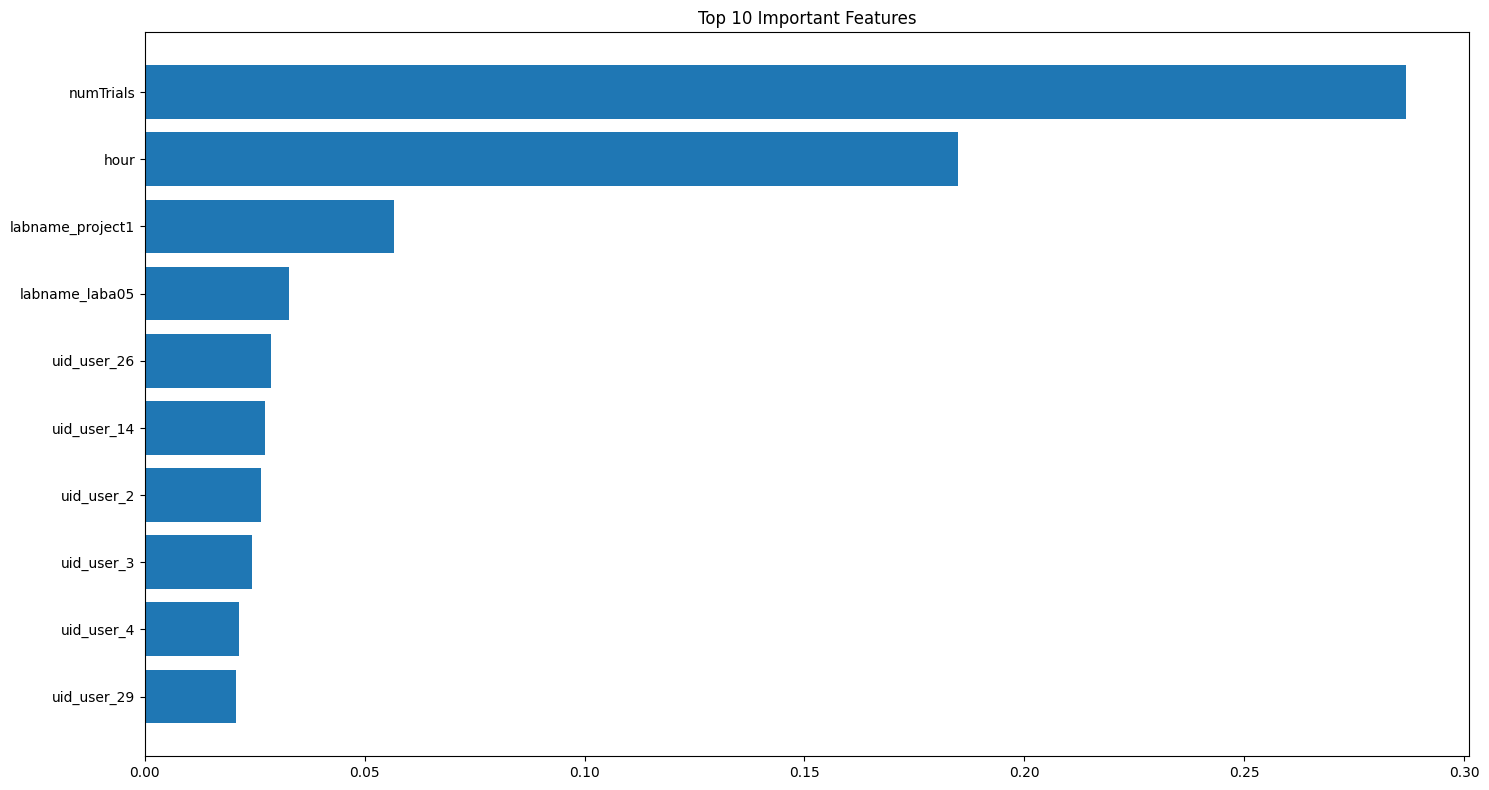

In [20]:
# Feature importance
feature_importances = final_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[-10:]

plt.figure(figsize=(15, 8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.title("Top 10 Important Features")
plt.tight_layout()
plt.show()

In [21]:
# Save and load model
dump(final_model, '../data/dayofweek_model.joblib')
loaded_model = load('../data/dayofweek_model.joblib')

In [22]:
loaded_acc = loaded_model.score(X_test, y_test)
print(f"Loaded Model Test Accuracy: {loaded_acc:.4f}")

Loaded Model Test Accuracy: 0.9260
